# Default of Credit Card Clients Project - Group4

## I. Introduction
Amidst growing financial insecurity during the pandemic, unsecured debt has continued to rise (Frech et al., 2021). Consequently, the consumer credit market and risk prediction has been a matter of great speculation and fear, lest there be a repeat of the financial crises that rocked the economic world in the late 2000s: In 2006, Taiwan was rocked by a credit card debt crisis with debt from credit cards and cash cards reaching $268 billion USD and over half a million people unable to repay their loans (Yeh & Lien, 2009). As many could barely afford to pay the minimum credit card debt balance every month or continued to default on their payments, significant societal problems consequently plagued the country, many banks incurred heavy losses and the government eventually needed to step in to stabilize the financial system (Yeh & Lien, 2009). This situation arose because many banks in Taiwan had lowered the requirements for credit card approval in order to gain more customers within the increasingly competitive industry (Tsai, 2010). Such examples indicate that a strict assessment of an applicant’s capability to make their card payment is critical to a well-developed financial system and a business’s survivability in the banking industry. 

This project focuses on the case of customers default payments in Taiwan and finds the predictive accuracy of the probability of the customers to default. The purpose of this study is to assess the true probability of default because the real probability of default is unknown.

This project used the data from UCI Machine learning repository. As the response variable, this project used data from a binary variable, default payment (Yes = 1, No = 0). The following 23 factors were considered as explanatory variables in this study, which was based on a review of the literature:

* Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* Gender (1 = male; 2 = female).
* Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* Marital status (1 = married; 2 = single; 3 = others).
* Age (year).
* History of past payment. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months . . . 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* Amount of bill statement (NT dollar). 
* Amount of previous payment (NT dollar).

The objective of this project is to maintain ease of interpretation for the average reader. In line with this goal, we will simplify the models and methods of analysis we choose to use as well as exclude some features in the data set in favor of greater readability.



## II. Environment setup

### II-1. Import libraries

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import random
import plotly.express as px
import plotly.figure_factory as ff

from src import preprocess as pp
from src import summary_stats_function as ss
from src import metrics_function as cm
from src import function_count_plot as cp

ModuleNotFoundError: No module named 'xgboost'

### II-2. Data import and preparation

In [13]:
df = pd.read_csv("data/default_of_credit_card_clients.csv", skiprows=1)
# rename column to get rid of spaces 
df.rename(columns = {"default payment next month":"default_payment"}, inplace = True)

In [16]:
train_df, test_df = pp.preprocess(df, 0.8, 200)

# split into training and testing set for x and y
X_train, y_train = (train_df.drop(columns=["default_payment"]),
                   train_df["default_payment"])

X_test, y_test = (test_df.drop(columns=["default_payment"]),
                  test_df["default_payment"])

The dataset was split into a 80% training and 20% testing set. The model will be built using only the training data. This gives the abilithy to compute a final performance metric for our model by evaluating it on the testing data. train_test_split() function shuffles the data to ensure the data ending up in the training and test sets is randomized. 

## III. Exploratory Data Analysis

### III-1. Dataset overview

First we have a look at our dataset:

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Then we check the number of rows and columns:

In [6]:
df.shape

(30000, 25)

Hence, there are 25 variables and 30,000 entries in this dataset.

### III-2. Check missing values

Now let's check if the dataset has null/missing values that may affect further analysis:

In [7]:
df.isnull().sum()

ID                 0
LIMIT_BAL          0
SEX                0
EDUCATION          0
MARRIAGE           0
AGE                0
PAY_0              0
PAY_2              0
PAY_3              0
PAY_4              0
PAY_5              0
PAY_6              0
BILL_AMT1          0
BILL_AMT2          0
BILL_AMT3          0
BILL_AMT4          0
BILL_AMT5          0
BILL_AMT6          0
PAY_AMT1           0
PAY_AMT2           0
PAY_AMT3           0
PAY_AMT4           0
PAY_AMT5           0
PAY_AMT6           0
default_payment    0
dtype: int64

Great! The dataset is super clean, and no missing value is found.

### III-3. Statistics information

This part we have a look at some basic statistics of the training set:

In [17]:
summary = ss.get_summary_stats(train_df)

In [18]:
summary

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
mean,14976.622417,166849.320000,1.604667,1.853375,1.555042,35.419625,-0.013917,-0.133917,-0.164833,-0.216500,...,43104.474417,40229.075458,38779.374000,5616.939125,5.887682e+03,5167.879500,4829.719292,4737.680583,5215.202875,0.223625
std,8653.230896,129755.438651,0.488932,0.786809,0.522477,9.184610,1.126400,1.204523,1.203526,1.173677,...,63907.819082,60576.642314,59440.281496,16379.132646,2.302808e+04,17554.292673,16048.880579,15344.499101,18288.995416,0.416682
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


We can see the following information:
1. The average amount of given credit in NT dollars is 166849.320000;
2. The average age of all clients is 35.419625, etc.

To better understand the correlation between variables, we would like to compute and visualize the correlations:

<AxesSubplot:>

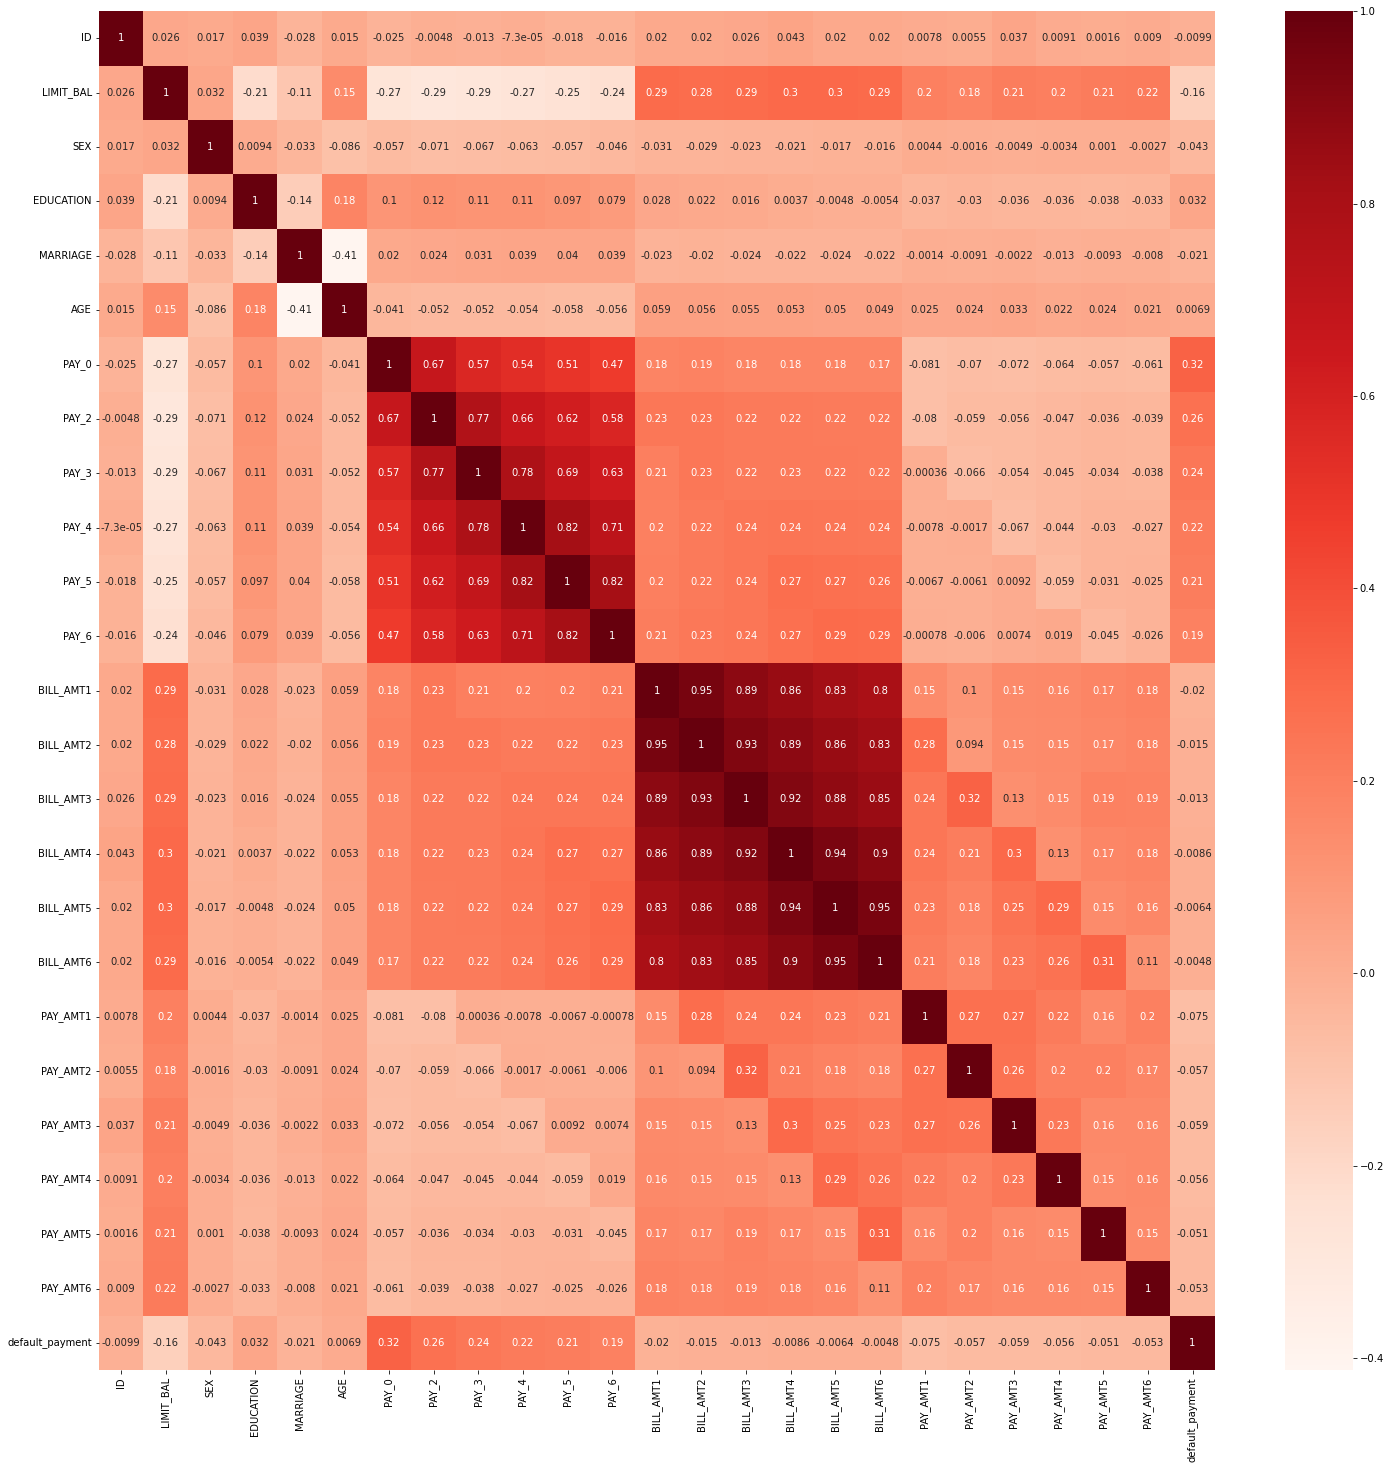

In [19]:
plt.figure(figsize=(25,25))
sns.heatmap(train_df.corr(),cbar=True,annot=True,cmap='Reds')

The heatmap shows some positive/negative correlations:

Positive correlations:
1. Default payment - PAY_0 to PAY_6 (Repayment status from April to September, 2005);
2. Limit balance - BILL_AMT1 to BILL_AMT6 (Amount of bill statement from April to September, 2005), etc.

Negative correlations:
1. Limit balance - PAY_0 to PAY_6 (Repayment status from April to September, 2005), etc.

Specifically, PAY_0 has the highest correlation with default_payment. This will give us a signal that PAY_0 plays an important role for predicting default_payment.


### III-4. Exploring variables

#### 1. LIMIT_BAL

First, we look at the amount of given credit (in NT dollars). Credit card limits are likely an indictor of how wealthy someone is since banks tend to give higher limits to clients that have more money with them. Thus, this may be an important feature when predicting if someone is able to pay the bill on time. 

/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

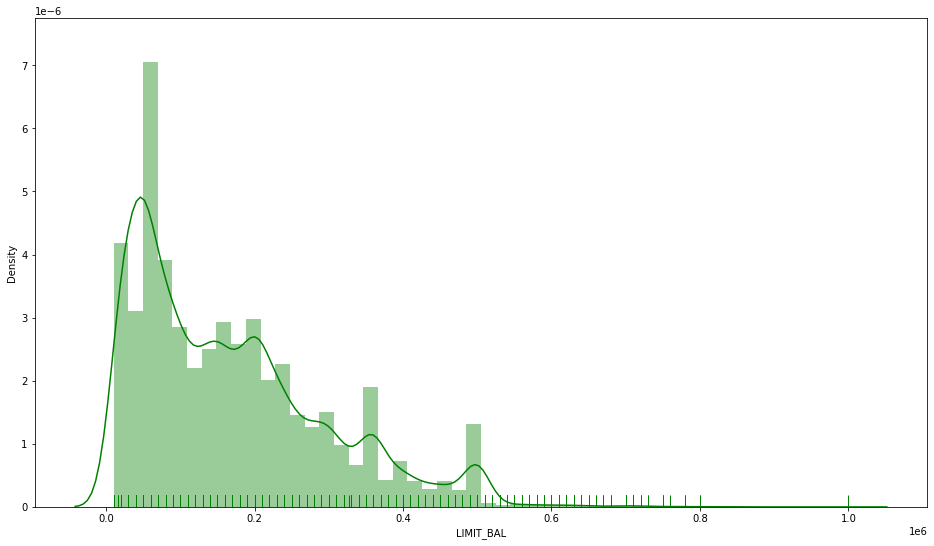

In [10]:
plt.figure(figsize = (16,9))
sns.distplot(train_df['LIMIT_BAL'],kde=True,bins=50, rug = True, color="green")

#### 2. Repayment Status

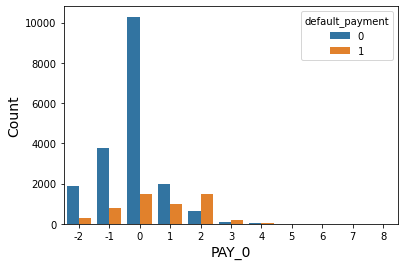

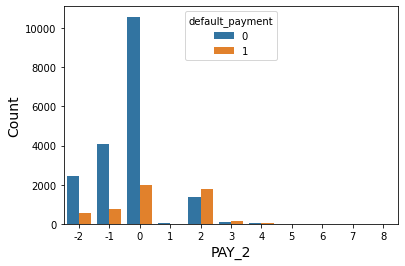

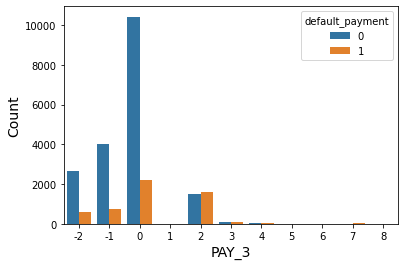

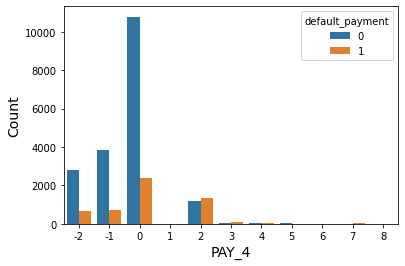

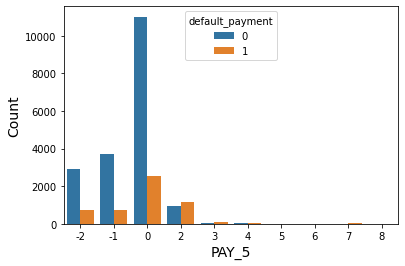

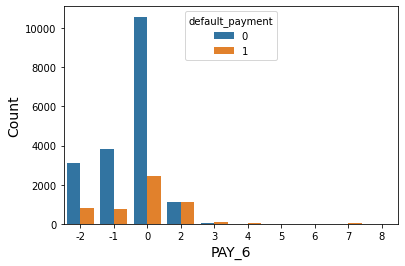

In [11]:
for column in train_df[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]:
    edu_plot = cp.count_plot(train_df, column, "Count Plot")
    plt.show()

Looking at the above plots on repayment status shows that if a client defaults on their payment for 2 months (e.g PAY_X = 2), it is a indicator to predict that default_payment = 1. It looks like repayment status will be an important feature in the model.

## IV. Analysis

### IV-1. Class Imbalance

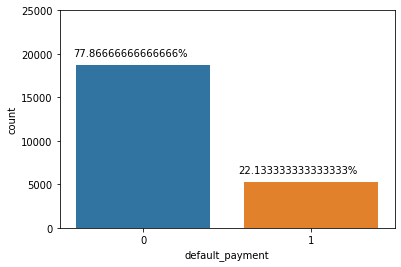

In [12]:
plt.figure(figsize=(6,4))

default_plot = sns.countplot(x = "default_payment",data = train_df)
plt.ylim(0,25000)
total = float(len(train_df))
for p in default_plot.patches:
    default_plot.annotate((str(100* p.get_height()/total) + "%"), (p.get_x()+0.32, p.get_height()+1000), ha="center")


plt.show()



The above plot shows the percentage of rows with default payment = 0 versus default payment = 1. Cleary there is class imbalance in this dataset. Because of this, we will use the area under the Receiver Operating Characterisitc curve (ROC AUC) as our primary metric to evaluate our model instead of accuracy, which tends to be missleading in cases of class imbalance. ROC AUC evalauates how good the model is as distinguishing between classes, and gives a more accurate sense of how well our model generalizes when dealing with class imbalance.

### IV-2. Preprossesing 

We apply scaling to numeric features to ensure the model built will be robust and not sensitive to the scale of each individual feature. To do this, we use the StandardScaler() function to set the sample mean to 0 and standard deviation to 1.

To handle categorical values, we will apply one-hot-encoding. This creates binary dummy variables for each category. 

There are no null values in the dataset so there is no need to handle missing values. 

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 25154 to 3532
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               24000 non-null  int64
 1   LIMIT_BAL        24000 non-null  int64
 2   SEX              24000 non-null  int64
 3   EDUCATION        24000 non-null  int64
 4   MARRIAGE         24000 non-null  int64
 5   AGE              24000 non-null  int64
 6   PAY_0            24000 non-null  int64
 7   PAY_2            24000 non-null  int64
 8   PAY_3            24000 non-null  int64
 9   PAY_4            24000 non-null  int64
 10  PAY_5            24000 non-null  int64
 11  PAY_6            24000 non-null  int64
 12  BILL_AMT1        24000 non-null  int64
 13  BILL_AMT2        24000 non-null  int64
 14  BILL_AMT3        24000 non-null  int64
 15  BILL_AMT4        24000 non-null  int64
 16  BILL_AMT5        24000 non-null  int64
 17  BILL_AMT6        24000 non-null  int64
 18  PAY

In [20]:
numeric_feats = [     # apply scaling
    "LIMIT_BAL",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4", 
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "AGE",
]

categorical_feats = [  # apply one-hot encoding
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "EDUCATION",
    "SEX",
    "MARRIAGE",
]

Next, we apply scaling and one-hot-encoding through using a column transformer, which applies the transformations to each column specified. 

In [21]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats,),
    (OneHotEncoder(handle_unknown="ignore"), categorical_feats,),

)

### IV-3. Model 0: Dummy Classifier

Firstly, we will try a baseline model to act as a comparison measure for the final model built. Using a pipeline to do this ensures that the model is built using just the training data, and that the testing data has no influence on the model. 5-fold Cross validation is used to give a more robust measure of performance error. K-fold Cross-validation spilts the training data into k folds, and each time one fold is the validation set. Each fold fits the model on the training portion and uses one fold as a validation set to calculate a performance metric, which can be averaged to get a overall score of how well the model does. This ensures that outliers don't negatively influence the performance metric. 

In [22]:
from sklearn.model_selection import cross_val_predict

dummy = DummyClassifier()

pipe = make_pipeline(ct, dummy)

scores = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5, scoring="roc_auc")
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_score,train_score
0,0.091479,0.025225,0.5,0.5
1,0.070808,0.018991,0.5,0.5
2,0.049411,0.015554,0.5,0.5
3,0.093025,0.035430,0.5,0.5
4,0.086876,0.037128,0.5,0.5


### IV-4. Model 1: Logistic Regression

Next, a logistic regression model is fitted to the training data. Logistic regression uses the training data to learn coefficients, which then can be used to calculate prediction probabilities of the each class using the sigmoid function. This allows us to calculate the probability of a client defaulting on their credit card based on their data. The hyperparameter C is used to control the fundatamental tradeoff of bias and variance, to reduce the likeliness of the model overfitting or underfitting. We chose logistic regression over more complex classifiers such as ensemble trees because it is easier to interpret and efficient to train. The predicted coeficients give information about feature importance and direction of association, making the model easily interpreted. Moreover, since the dataset is significantly larger than the number of features, logistic regression is less likely to overfit because it is a low variance model.

Hyperparameter optimization is carried out to find the best value of C for the data in hopes to reduce bias and variance. Cross-validation is used to test how well the model performs on unseen data during hyperparemter opimization, enabling performance metrics to be calculated to compare different values of C.

In [23]:
random.seed()

train_scores = []
cv_scores = []

C = 10.0 ** np.arange(-1.5, 2, 0.5)

for c in C:
    
    pipe_lr = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=c),
    )
    
    results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True, scoring = "roc_auc")
    
    train_scores.append(results["train_score"].mean())
    cv_scores.append(results["test_score"].mean())
    

scores = pd.DataFrame({"C": C, "Train Scores": train_scores, "CV Scores": cv_scores })

scores

,C,Train Scores,CV Scores
0,0.031623,0.772475,0.768900
1,0.100000,0.772752,0.768673
2,0.316228,0.772831,0.768428
3,1.000000,0.772920,0.768224
4,3.162278,0.772998,0.767907
5,10.000000,0.773069,0.767455
6,31.622777,0.773136,0.767141


In [24]:
best_C = scores.loc[scores["CV Scores"].idxmax(), "C"]
print("best C value: " + str(best_C))

best C value: 0.03162277660168379


Next, the logistic regression model with the optimized C value is fitted to the training data. The model is built using pipelines to ensure all data preprocessing is constant and that no information from the testing set leaks into the training of the model.

In [25]:
random.seed()

model = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, C=best_C),
    )

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'PAY_AMT1',
                                                   'PAY_AMT2', 'PAY_AMT3',
                                                   'PAY_AMT4', 'PAY_AMT5',
                                                   'PAY_AMT6', 'AGE']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'P

### IV-5. Feature Importance

Next, we will look at feature importance. In logistic regression, the magnitude and direction of the learned coefficients explain the relationship between a explanatory feature and the response variable.

In [26]:
ohe_feature_names = (
    model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names()
    .tolist()
)


feat_names = (numeric_feats + ohe_feature_names)

In [27]:


coefs = {
    "coefficient": model.named_steps["logisticregression"].coef_[0].tolist(),
    "absolute_value": np.absolute(
        model.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
df_coefs = pd.DataFrame(coefs, index=feat_names).sort_values(
    "absolute_value", ascending=False
)

df_coefs[:10]

,coefficient,absolute_value
x0_2,1.061312,1.061312
x0_0,-1.004570,1.004570
x0_3,0.721913,0.721913
x0_-2,-0.668843,0.668843
x5_0,-0.321994,0.321994
x6_5,-0.317669,0.317669
x0_-1,-0.314837,0.314837
LIMIT_BAL,-0.248907,0.248907
x5_3,0.248900,0.248900
x2_2,0.245034,0.245034


The table above shows the most important features according to the model. Positive coefficients indicate that an increase in the feature increases the probability that the response variable is class 1, and negative coefficients indicate that a increases in the feature decreases the probability that the response variable is class 1.

The most important feature is repayment status in April with a 2 month delay.

x0_2 $= \begin{cases}
    1     &\text{if repayment status in April was delayed 2 months} \\
    0     &\text{else}
    \end{cases}$

To further interpret this, the odds ratio can be calculated. $OR = e^{\beta}$,  where $\beta$ is a model coefficient.

In [28]:
x0_2_OR = np.exp(df_coefs.iat[0,0])
x0_2_OR

2.890159014142167

The odds ratio for x0_2 can be interpreted as clients who delayed payment for 2 months in April have about 2.9 times the odds of defaulting their credit card payment next month than those who did not delay for 2 months of, controlling for the other features since there is some correlation.

It makes logical sense that this feature is important since it was highly correlated with the response variable during the exploratory data analysis, and because it makes sense that if someone has delayed payment in the past they may not be able to pay in the future as well.

Another important feature is x0_0, corresponding to repayment status in April with a revolving credit. The magnitude is negative here meaning that a value of 1 for this binary variable is negatively associated with defaulting next month. This makes sense because revolving credit lets clients pay a minimum balance instead of the full bill, making them less likely to default. The odds ratio is calculated below.

In [23]:
x0_0_OR = np.exp(df_coefs.iat[1,0])
x0_0_OR

0.3767234382064208

The odds ratio above shows that clients who had a repayment status of using a revolving credit in April decreases the odds of class 1 versus class 0 by about 63%, controlling for the other features.

Due to the large number of features, we only looked at the first 2 most important features, however this method can be done for the remaining features as well.

### IV-6. Testing the Model

Finally, the model will be evaluated by predicting on the test dataset. Performance metrics including area under the ROC curve, f1-score, precision and recall will be calculated. Precision is the ratio of true postive and total positives. Recall is the measure of the model correctly identifying true positives. F1-score is the harmonic mean of precision and recall.

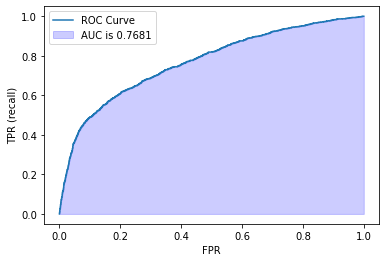

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# prediction probabilities on test set 
lr_prob = model.predict_proba(X_test)[:,1]

# roc_auc score on test set 
roc_lr = roc_auc_score(y_test, lr_prob)

fpr, tpr, thresholds = roc_curve(y_test, lr_prob)

roc_lr = round(roc_lr, 4)

auc_label = "AUC is " + str(roc_lr)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.fill_between(fpr, tpr, color='blue', alpha=0.2, label=auc_label)

plt.legend(loc="best");

The test ROC AUC is almost the same as the cross-validation ROC AUC so we can conclude that there is little optimization bias and we are not overfitting. Area under the ROC curve is the classifier's ability to distinguish between classes. So 78% of the time, the model is able to correctly distinguish between class 0 and class 1.

In [34]:
predict = model.predict(X_test)

TN, FP, FN, TP = confusion_matrix(y_test, predict).ravel()

res = cm.calculate_metrics(TN, FP, FN, TP)

# res = classification_report(
#         y_test, predict, target_names=["non-default", "default"]
#     )

res

,recall,precision,f1 score
0,0.359,0.669,0.467


/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


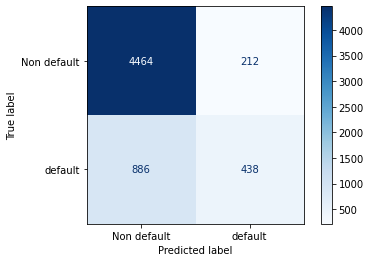

In [26]:
plot_confusion_matrix(
    model,
    X_test,
    y_test,
    display_labels=["Non default", "default"],
    values_format="d",
    cmap=plt.cm.Blues,
);

 It appears that the model does significantly better for the non-default class, since precision, recall, and f1-score are very high. Recall is partically low for the default class, and very high for the non-default class. Thus this model is very good at indentifying clients who will pay their bill on time. Precision can be intrepreted as when the model predicts class 0 (non-default) it is correct 84% of the time, and when it predicts class 1 it is correct 64% of the time, which is not as good. 

## V. Discussion

Looking at the results above, the analysis has a few limitations. One of the main limitations is the extrapolation of data. The dataset used was from Taiwan so the model may not apply properly for financial institutions and people outside of Taiwan. The other limitation is that logistic regression favors interpretability over prediction accuracy. The coefficients are easy to understand while the logistic regression is not as accurate as other algorithms.

Another limitation of the analysis is that logistic regression is a higher bias model than other classifiers such as ensemble trees. This means that the model pays less attention to the training data and may oversimplify it, resulting in less accuracy. However, the results show that the model did very well when predicting clients who did not default next month (class 0). The high recall and precision score for class 0 suggest this model can be very useful when trying to distinguish if a client will pay the bill on time.  Thus, this model can be used to help financial institutions make various risk decisions about a client including whether to offer someone a loan or whether to raise the credit card monthly limit. A prediction probability can be calculated based on the input features of each individual client. A prediction probability close to 0 indicates that the client is likely to pay the credit card bill. 

According to the model, the most important feature was repayment status. Specifically, whether or not someone delayed payment for 2 months, and whether or not someone used a revolving credit card. This provides insight into what features financial institutions should look for when assessing risk for individual clients. Also, the model suggests that giving someone a revolving credit card where they only have to pay a minimum balance instead of the whole bill each month reduces the probability of the client defaulting. This information could be used to prevent the institute from losing money due to people defaulting. 

Overall, the model provides insight into important features that may benefit financial institutions when managing risk, and allows an institute to calculate the probability that an individual client will default. 


## VI. References
Dua, D., & Graff, C. (2016). UCI Machine Learning Repository: default of credit card clients Data Set [Data set].  University of California, Irvine, School of Information and Computer Science. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Frech, A., Houle, J., & Tumin, D. (2021). Trajectories of unsecured debt and health at midlife. SSM - Population Health, 15, 100846. https://doi.org/10.1016/j.ssmph.2021.100846

Tsai, B.-H. (2010). Gauging bank efficiency during card insolvency crisis: the case of the Taiwanese banks. The Journal of Developing Areas, 44(1), 267–285. https://doi.org/10.1353/jda.0.0087

Yeh, I-Cheng., & Lien, C. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473–2480. https://doi.org/10.1016/j.eswa.2007.12.020